In [177]:
import torch
import matplotlib.pyplot as plt
print(torch.__version__)

0.4.1


In [73]:
import pprint
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
pp = pprint.PrettyPrinter(indent=4)
from operator import itemgetter

# First lets improve libraries that we are going to be used in this lab session
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
random.seed(134)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 64

In [3]:
fasttest_home = './'
words_to_load = 50000

import numpy as np

with open(fasttest_home + 'wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft = np.zeros((words_to_load, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i, :] = np.asarray(s[1:])
        words_ft[s[0]] = i
        idx2words_ft[i] = s[0]
        ordered_words_ft.append(s[0])

In [434]:
import pandas as pd
train = pd.read_csv('hw2_data/snli_train.tsv', sep='\t')
val = pd.read_csv('hw2_data/snli_val.tsv', sep='\t')

In [5]:
def read_data(dataset):
    n = len(dataset)
    result = []
    def embeddingx(wordlist):
        n = len(wordlist)
        embvalue = np.zeros((n,300)) 
        for i in range(n):
            if wordlist[i] in words_ft.keys():
                embvalue[i] = loaded_embeddings_ft[words_ft[wordlist[i]]]
            else:
                embvalue[i] = np.zeros(300)
        return embvalue
    for i in range(n):
        x1 = dataset.iloc[i].sentence1.split(' ')
        x2 = dataset.iloc[i].sentence2.split(' ')
        y = dataset.iloc[i].label
        if y == 'contradiction':
            y = 0
        elif y == 'entailment' :
            y = 1
        elif y == 'neutral' :
            y = 2
        else:
            print('Value Error')
        xemb1 =  embeddingx(x1)
        xemb2 =  embeddingx(x2)
        result.append(((xemb1,xemb2),y))
    return result

In [6]:
def read_data_with_padding(dataset):
    n = len(dataset)
    result = []
    def embeddingx(wordlist):
        #n = len(wordlist)
        embvalue = np.zeros((MAX_SENTENCE_LENGTH,300)) 
        for i in range(MAX_SENTENCE_LENGTH):
            if i == len(wordlist):
                break
            if wordlist[i] in words_ft.keys():
                embvalue[i] = loaded_embeddings_ft[words_ft[wordlist[i]]]
            else:
                embvalue[i] = np.zeros(300)
        return embvalue
    for i in range(n):
        x1 = dataset.iloc[i].sentence1.split(' ')
        x2 = dataset.iloc[i].sentence2.split(' ')
        y = dataset.iloc[i].label
        if y == 'contradiction':
            y = 0
        elif y == 'entailment' :
            y = 1
        elif y == 'neutral' :
            y = 2
        else:
            print('Value Error')
        xemb1 =  embeddingx(x1)
        xemb2 =  embeddingx(x2)
        result.append(((xemb1,xemb2),y))
    return result

In [578]:
trainset = read_data(train)
valset = read_data(val)

In [579]:
class VocabDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_tuple):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.data_list, self.target_list = zip(*data_tuple)
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        data = self.data_list[key]
        label = self.target_list[key]
        return [data, (len(data[0]),len(data[1])), label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    MAX_SENTENCE_LENGTH = 30
    
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []

    for datum in batch:
        label_list.append(datum[2])
        length_list1.append(datum[1][0])
        length_list2.append(datum[1][1])
        length_list1 = [MAX_SENTENCE_LENGTH if length>MAX_SENTENCE_LENGTH else length for length in length_list1]
        length_list2 = [MAX_SENTENCE_LENGTH if length>MAX_SENTENCE_LENGTH else length for length in length_list2]

    #padding
    for datum in batch:
        if MAX_SENTENCE_LENGTH > datum[1][0]:
            padded_vec1 = np.pad(np.array(datum[0][0]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1][0]),(0,0)),
                                mode="constant", constant_values=0)
        else:
            padded_vec1 = np.array(datum[0][0])[:MAX_SENTENCE_LENGTH]
        
        if MAX_SENTENCE_LENGTH > datum[1][1]:
            padded_vec2 = np.pad(np.array(datum[0][1]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1][1]),(0,0)),
                                mode="constant", constant_values=0)
        else:
            padded_vec2 = np.array(datum[0][1])[:MAX_SENTENCE_LENGTH]
        data_list1.append(padded_vec1)
        data_list2.append(padded_vec2)
    
    ind_dec_order1 = np.argsort(length_list1)[::-1]
    ind_dec_order2 = np.argsort(length_list2)[::-1]
    data_list1 = np.array(data_list1)[ind_dec_order1]
    data_list2 = np.array(data_list2)[ind_dec_order2]
    
    length_list1 = np.array(length_list1)[ind_dec_order1]
    length_list2 = np.array(length_list2)[ind_dec_order2]
    
    #label_list = np.array(label_list)[ind_dec_order]
    return [(torch.FloatTensor(np.array(data_list1)),torch.FloatTensor(np.array(data_list2))), (torch.LongTensor(length_list1),torch.LongTensor(length_list2)), torch.LongTensor(label_list),(np.argsort(ind_dec_order1),np.argsort(ind_dec_order2))]
    #return [(torch.from_numpy(np.array(data_list1)),torch.from_numpy(np.array(data_list2))), (torch.LongTensor(length_list1),torch.LongTensor(length_list2)), torch.LongTensor(label_list),(np.argsort(ind_dec_order1),np.argsort(ind_dec_order2))]



In [580]:
# Build train, valid and test dataloaders

train_dataset = VocabDataset(trainset)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = VocabDataset(valset)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)


In [581]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        #self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.rnn1 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional = True)
        self.rnn2 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional = True)
        self.linear1 = nn.Linear(hidden_size * 4, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)
#         self.iii = 0

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers * 2, batch_size, self.hidden_size).cuda()

        return hidden

    def forward(self, x, lengths,reindex):
        # reset hidden state
        
        batch_size, seq_len, _ = x[0].size()

        self.hidden = self.init_hidden(batch_size)

        # get embedding of characters
        #embed = self.embedding(x)
        # pack padded sequence
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(x[0], lengths[0], batch_first=True)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(x[1], lengths[1], batch_first=True)
        # fprop though RNN
        #print(self.hidden.size())
        rnn_out1, self.hidden1 = self.rnn1(embed1, self.hidden)
        rnn_out2, self.hidden2 = self.rnn2(embed2, self.hidden)
        # undo packing
        rnn_out1, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out1, batch_first=True)
        rnn_out2, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out2, batch_first=True)
        
        reindex = torch.from_numpy(np.array(reindex))
        
        self.hidden1 = self.hidden1.index_select(1,reindex[0].cuda())
        self.hidden2 = self.hidden2.index_select(1,reindex[1].cuda())   
        
        rnn_out = torch.cat((self.hidden1, self.hidden2), -1) 
        # sum hidden activations of RNN across time
        rnn_out = rnn_out.transpose(0,1)
        rnn_out = rnn_out.contiguous().view(batch_size,self.hidden_size*4)
        
        #rnn_out = torch.sum(rnn_out, dim=0)
        rnn_out = self.linear1(rnn_out)
        rnn_out = F.relu(rnn_out)
        logits = self.linear2(rnn_out)
        return logits



In [179]:
MAX_SENTENCE_LENGTH = 30
def hyperparameter_testRNN(hidden_size):
    def test_model(loader, model):
        """
        Help function that tests the model's performance on a dataset
        @param: loader - data loader for the dataset to test against
        """
        correct = 0
        total = 0
        model.eval()
        for data, lengths, labels, reindex in loader:
            data, lengths, labels, reindex = (data[0].to(device),data[1].to(device)), (lengths[0].to(device),lengths[1].to(device)), labels.to(device), reindex
            data_batch, lengths_batch, label_batch = data, lengths, labels
            outputs = F.softmax(model(data_batch, lengths_batch,reindex), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]

            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
        return (100 * correct / total)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = RNN(emb_size=300, hidden_size=hidden_size, num_layers=1, num_classes=3)
    model.cuda()
    
    learning_rate = 1e-3
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    
    losslist = []
    train_acc_list = []
    val_acc_list = []
    
    for epoch in range(num_epochs):
        for i, (data, lengths, labels, reindex) in enumerate(train_loader):
            data, lengths, labels, reindex = (data[0].to(device),data[1].to(device)), (lengths[0].to(device),lengths[1].to(device)), labels.to(device), reindex
            model.train()
            optimizer.zero_grad()
            # Forward pass
            #print(data[0].size())
            outputs = model(data, lengths, reindex)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                #val_acc = test_model(val_loader, model)
            #    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
            #       epoch+1, num_epochs, i+1, len(train_loader),val_acc))
                # validate
                train_acc = test_model(train_loader, model)
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}, Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), train_acc,val_acc))
                #print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                #           epoch+1, num_epochs, i+1, len(train_loader),val_acc))
                losslist.append(loss.data)
                train_acc_list.append(train_acc)
                val_acc_list.append(val_acc)
    return losslist,train_acc_list,val_acc_list


In [188]:
#losslist1,train_acc_list1,val_acc_list1 = hyperparameter_testRNN(hidden_size=100)
#print('*****************************')
#losslist2,train_acc_list2,val_acc_list2 = hyperparameter_testRNN(hidden_size=150)
#print('*****************************')
losslist3,train_acc_list3,val_acc_list3 = hyperparameter_testRNN(hidden_size=200)

cuda:0
Epoch: [1/10], Step: [101/1563], Train Acc: 51.214, Validation Acc: 49.8
Epoch: [1/10], Step: [201/1563], Train Acc: 53.819, Validation Acc: 53.4
Epoch: [1/10], Step: [301/1563], Train Acc: 55.533, Validation Acc: 54.7
Epoch: [1/10], Step: [401/1563], Train Acc: 53.17, Validation Acc: 54.0
Epoch: [1/10], Step: [501/1563], Train Acc: 57.795, Validation Acc: 58.4
Epoch: [1/10], Step: [601/1563], Train Acc: 57.574, Validation Acc: 56.7
Epoch: [1/10], Step: [701/1563], Train Acc: 57.161, Validation Acc: 56.2
Epoch: [1/10], Step: [801/1563], Train Acc: 57.678, Validation Acc: 57.6
Epoch: [1/10], Step: [901/1563], Train Acc: 60.475, Validation Acc: 59.7
Epoch: [1/10], Step: [1001/1563], Train Acc: 60.76, Validation Acc: 60.1
Epoch: [1/10], Step: [1101/1563], Train Acc: 60.582, Validation Acc: 61.4
Epoch: [1/10], Step: [1201/1563], Train Acc: 60.972, Validation Acc: 59.8
Epoch: [1/10], Step: [1301/1563], Train Acc: 61.924, Validation Acc: 62.4
Epoch: [1/10], Step: [1401/1563], Train Ac

Epoch: [8/10], Step: [801/1563], Train Acc: 82.201, Validation Acc: 68.4
Epoch: [8/10], Step: [901/1563], Train Acc: 82.668, Validation Acc: 69.8
Epoch: [8/10], Step: [1001/1563], Train Acc: 83.015, Validation Acc: 69.9
Epoch: [8/10], Step: [1101/1563], Train Acc: 83.337, Validation Acc: 70.2
Epoch: [8/10], Step: [1201/1563], Train Acc: 83.486, Validation Acc: 69.7
Epoch: [8/10], Step: [1301/1563], Train Acc: 83.503, Validation Acc: 69.8
Epoch: [8/10], Step: [1401/1563], Train Acc: 84.104, Validation Acc: 69.7
Epoch: [8/10], Step: [1501/1563], Train Acc: 84.009, Validation Acc: 68.2
Epoch: [9/10], Step: [101/1563], Train Acc: 84.567, Validation Acc: 69.1
Epoch: [9/10], Step: [201/1563], Train Acc: 84.997, Validation Acc: 67.7
Epoch: [9/10], Step: [301/1563], Train Acc: 85.125, Validation Acc: 71.1
Epoch: [9/10], Step: [401/1563], Train Acc: 84.807, Validation Acc: 68.7
Epoch: [9/10], Step: [501/1563], Train Acc: 85.239, Validation Acc: 69.4
Epoch: [9/10], Step: [601/1563], Train Acc: 8

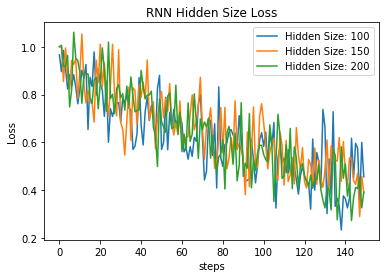

In [189]:
plt.plot(losslist1,label = 'Hidden Size: 100')
plt.plot(losslist2,label = 'Hidden Size: 150')
plt.plot(losslist3,label = 'Hidden Size: 200')
plt.xlabel('steps')
plt.ylabel('Loss')
plt.title('RNN Hidden Size Loss')
plt.legend(loc = 'upper right')
#plt.show()
plt.savefig('./image/RNN_hidden_loss.png',dpi = 200)

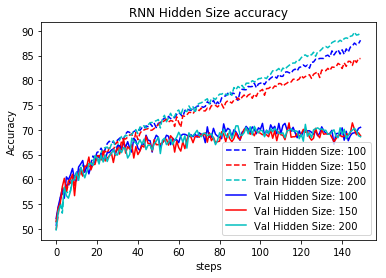

In [190]:
plt.plot(train_acc_list1,'b--',label = 'Train Hidden Size: 100')
plt.plot(train_acc_list2,'r--',label = 'Train Hidden Size: 150')
plt.plot(train_acc_list3,'c--',label = 'Train Hidden Size: 200')
plt.plot(val_acc_list1,label = 'Val Hidden Size: 100',color='Blue')
plt.plot(val_acc_list2,label = 'Val Hidden Size: 150',color='Red')
plt.plot(val_acc_list3,label = 'Val Hidden Size: 200',color = 'c')

plt.xlabel('steps')
plt.ylabel('Accuracy')
plt.title('RNN Hidden Size accuracy')
plt.legend(loc = 'lower right')
#plt.show()
plt.savefig('./image/RNN_hidden_train_val.png',dpi = 200)

In [582]:
MAX_SENTENCE_LENGTH = 30
def hyperparameter_testRNN(hidden_size,train_loader,val_loader):
    def test_model(loader, model):
        """
        Help function that tests the model's performance on a dataset
        @param: loader - data loader for the dataset to test against
        """
        correct = 0
        total = 0
        model.eval()
        for data, lengths, labels, reindex in loader:
            data, lengths, labels, reindex = (data[0].to(device),data[1].to(device)), (lengths[0].to(device),lengths[1].to(device)), labels.to(device), reindex
            data_batch, lengths_batch, label_batch = data, lengths, labels
            outputs = F.softmax(model(data_batch, lengths_batch,reindex), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]

            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
        return (100 * correct / total)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = RNN(emb_size=300, hidden_size=hidden_size, num_layers=1, num_classes=3)
    model.cuda()
    
    learning_rate = 1e-3
    num_epochs = 9 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    
    max_acc = 0
    bestmodel = model

    for epoch in range(num_epochs):
        for i, (data, lengths, labels, reindex) in enumerate(train_loader):
            data, lengths, labels, reindex = (data[0].to(device),data[1].to(device)), (lengths[0].to(device),lengths[1].to(device)), labels.to(device), reindex
            model.train()
            optimizer.zero_grad()
            # Forward pass
            #print(data[0].size())
            outputs = model(data, lengths, reindex)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                #val_acc = test_model(val_loader, model)
            #    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
            #       epoch+1, num_epochs, i+1, len(train_loader),val_acc))
                # validate
                #train_acc = test_model(train_loader, model)
                val_acc = test_model(val_loader, model)
                #print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}, Validation Acc: {}'.format(
                #           epoch+1, num_epochs, i+1, len(train_loader), train_acc,val_acc))
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader),val_acc))
                if val_acc > max_acc:
                    print('bestacc:', val_acc)
                    bestmodel = model
                    max_acc = val_acc

    return bestmodel


In [583]:
BestRNNmodel1 = hyperparameter_testRNN(150,train_loader,val_loader)

cuda:0
Epoch: [1/9], Step: [101/1563], Validation Acc: 51.2
bestacc: 51.2
Epoch: [1/9], Step: [201/1563], Validation Acc: 54.1
bestacc: 54.1
Epoch: [1/9], Step: [301/1563], Validation Acc: 53.7
Epoch: [1/9], Step: [401/1563], Validation Acc: 57.5
bestacc: 57.5
Epoch: [1/9], Step: [501/1563], Validation Acc: 58.0
bestacc: 58.0
Epoch: [1/9], Step: [601/1563], Validation Acc: 56.9
Epoch: [1/9], Step: [701/1563], Validation Acc: 57.4
Epoch: [1/9], Step: [801/1563], Validation Acc: 57.8
Epoch: [1/9], Step: [901/1563], Validation Acc: 57.9
Epoch: [1/9], Step: [1001/1563], Validation Acc: 59.4
bestacc: 59.4
Epoch: [1/9], Step: [1101/1563], Validation Acc: 60.2
bestacc: 60.2
Epoch: [1/9], Step: [1201/1563], Validation Acc: 61.5
bestacc: 61.5
Epoch: [1/9], Step: [1301/1563], Validation Acc: 61.3
Epoch: [1/9], Step: [1401/1563], Validation Acc: 61.6
bestacc: 61.6
Epoch: [1/9], Step: [1501/1563], Validation Acc: 63.3
bestacc: 63.3
Epoch: [2/9], Step: [101/1563], Validation Acc: 63.6
bestacc: 63.6

In [584]:
#torch.save(BestRNNmodel1,'./BestRNNmodel')
torch.save(BestRNNmodel1.state_dict(), './BestRNNmodel_state')

In [558]:
val_dataset = VocabDataset(valset)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=64,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)


In [448]:
test_model(val_loader,BestRNNmodel1)

70.6

In [268]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    predictlist = []
    datalist = []
    labellist = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    for data, lengths, labels, reindex in loader:
        data, lengths, labels, reindex = (data[0].to(device),data[1].to(device)), (lengths[0].to(device),lengths[1].to(device)), labels.to(device), reindex
        data_batch, lengths_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, lengths_batch,reindex), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        predictlist.append(predicted)
        datalist.append(data)
        labellist.append(labels)
    return predictlist,datalist,labellist

In [269]:
prelist,datalist,labellist = test_model(val_loader,BestRNNmodel)

In [315]:
prelist[20:30],labellist[20:30]

([tensor([[0]], device='cuda:0'),
  tensor([[2]], device='cuda:0'),
  tensor([[1]], device='cuda:0'),
  tensor([[0]], device='cuda:0'),
  tensor([[0]], device='cuda:0'),
  tensor([[2]], device='cuda:0'),
  tensor([[1]], device='cuda:0'),
  tensor([[1]], device='cuda:0'),
  tensor([[1]], device='cuda:0'),
  tensor([[2]], device='cuda:0')],
 [tensor([1], device='cuda:0'),
  tensor([2], device='cuda:0'),
  tensor([1], device='cuda:0'),
  tensor([1], device='cuda:0'),
  tensor([0], device='cuda:0'),
  tensor([2], device='cuda:0'),
  tensor([0], device='cuda:0'),
  tensor([1], device='cuda:0'),
  tensor([1], device='cuda:0'),
  tensor([2], device='cuda:0')])

In [309]:
val.iloc[21:30]

,sentence1,sentence2,label
21,A group of people are sitting under umbrellas ...,It is a saturday,neutral
22,A boy riding on a carnival ride turns around f...,A human riding,entailment
23,People walk amongst a traffic jam in a crowded...,The traffic is halted and people are walking b...,entailment
24,A live band on a lawn jamming out .,A band is practicing new tunes in the garage .,contradiction
25,man grilling fish on barbecue,The man likes to eat fish .,neutral
26,"A lone , 2-3 year old blond child in a blue ja...",The couch is pointed toward the front .,contradiction
27,A chef speaks into a microphone about a mixed ...,a chef speaks into a microphone near a bowl,entailment
28,Many people are smiling as they gather in a ro...,People are indoors .,entailment
29,Three cheerful ladies sitting at a table doing...,The ladies are discussing what they are going ...,neutral


In [310]:
val.iloc[26].sentence1

'A lone , 2-3 year old blond child in a blue jacket is putting a small black plastic item in his mouth as he kneels on a waiting room couch pointed toward the back while looking at something or someone not in the room .'

In [311]:
val.iloc[26].sentence2

'The couch is pointed toward the front .'

In [318]:
valMut = pd.read_csv('hw2_data/mnli_val.tsv', sep='\t')

In [450]:
valfic = valMut[valMut.genre == 'fiction']
valtel = valMut[valMut.genre == 'telephone']
valgov = valMut[valMut.genre == 'government']
valsla = valMut[valMut.genre == 'slate']
valtra = valMut[valMut.genre == 'travel']

In [466]:
valset = read_data(valtra)
val_dataset = VocabDataset(valset)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=64,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

In [464]:
def test_model(loader, model):
        """
        Help function that tests the model's performance on a dataset
        @param: loader - data loader for the dataset to test against
        """
        correct = 0
        total = 0
        model.eval()
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        for data, lengths, labels, reindex in loader:
            data, lengths, labels, reindex = (data[0].to(device),data[1].to(device)), (lengths[0].to(device),lengths[1].to(device)), labels.to(device), reindex
            data_batch, lengths_batch, label_batch = data, lengths, labels
            outputs = F.softmax(model(data_batch, lengths_batch,reindex), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]

            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
        return (100 * correct / total)

In [471]:
test_model(val_loader, BestRNNmodel1)

48.06517311608961

In [604]:
MAX_SENTENCE_LENGTH = 30
def hyperparameter_testRNN(train_loader,val_loader,hidden_size=150):
    def test_model(loader, model):
        """
        Help function that tests the model's performance on a dataset
        @param: loader - data loader for the dataset to test against
        """
        correct = 0
        total = 0
        model.eval()
        for data, lengths, labels, reindex in loader:
            data, lengths, labels, reindex = (data[0].to(device),data[1].to(device)), (lengths[0].to(device),lengths[1].to(device)), labels.to(device), reindex
            data_batch, lengths_batch, label_batch = data, lengths, labels
            outputs = F.softmax(model(data_batch, lengths_batch,reindex), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]

            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
        return (100 * correct / total)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = RNN(emb_size=300, hidden_size=hidden_size, num_layers=1, num_classes=3)
    
    model.load_state_dict(torch.load('BestRNNmodel_state'))

    #model = torch.load('BestRNNmodel')
    #for param in model.parameters():
    #    param.requires_grad = True
        
    model.cuda()
    
    learning_rate = 1e-3
    num_epochs = 3 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    
    max_acc = 0
    
    
    bestmodel = model
    for epoch in range(num_epochs):
        for i, (data, lengths, labels, reindex) in enumerate(train_loader):
            data, lengths, labels, reindex = (data[0].to(device),data[1].to(device)), (lengths[0].to(device),lengths[1].to(device)), labels.to(device), reindex
            model.train()
            optimizer.zero_grad()
            # Forward pass
            #print(data[0].size())
            outputs = model(data, lengths, reindex)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 20 == 0:
                #val_acc = test_model(val_loader, model)
            #    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
            #       epoch+1, num_epochs, i+1, len(train_loader),val_acc))
                # validate
                #train_acc = test_model(train_loader, model)
                val_acc = test_model(val_loader, model)
                #print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}, Validation Acc: {}'.format(
                #           epoch+1, num_epochs, i+1, len(train_loader), train_acc,val_acc))
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader),val_acc))
                #print('LOSS:', loss[0])
                if val_acc > max_acc:
                    bestmodel = model

    return bestmodel


In [605]:
trainMut = pd.read_csv('hw2_data/mnli_train.tsv', sep='\t')

In [606]:
trainfic = trainMut[trainMut.genre == 'fiction']
traintel = trainMut[trainMut.genre == 'telephone']
traingov = trainMut[trainMut.genre == 'government']
trainsla = trainMut[trainMut.genre == 'slate']
traintra = trainMut[trainMut.genre == 'travel']

In [611]:
BATCH_SIZE = 64
trainset = read_data(traintra)
valset = read_data(valtra)

train_dataset = VocabDataset(trainset)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = VocabDataset(valset)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)


In [612]:
bestmodel1 = hyperparameter_testRNN(train_loader,val_loader)

cuda:0
Epoch: [1/3], Step: [21/63], Validation Acc: 48.87983706720978
Epoch: [1/3], Step: [41/63], Validation Acc: 51.12016293279022
Epoch: [1/3], Step: [61/63], Validation Acc: 51.0183299389002
Epoch: [2/3], Step: [21/63], Validation Acc: 52.85132382892057
Epoch: [2/3], Step: [41/63], Validation Acc: 53.360488798370675
Epoch: [2/3], Step: [61/63], Validation Acc: 51.12016293279022
Epoch: [3/3], Step: [21/63], Validation Acc: 53.360488798370675
Epoch: [3/3], Step: [41/63], Validation Acc: 53.15682281059063
Epoch: [3/3], Step: [61/63], Validation Acc: 55.70264765784114


In [ ]:
def test_model(loader, model):
        """
        Help function that tests the model's performance on a dataset
        @param: loader - data loader for the dataset to test against
        """
        correct = 0
        total = 0
        model.eval()
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        for data, lengths, labels, reindex in loader:
            data, lengths, labels, reindex = (data[0].to(device),data[1].to(device)), (lengths[0].to(device),lengths[1].to(device)), labels.to(device), reindex
            data_batch, lengths_batch, label_batch = data, lengths, labels
            outputs = F.softmax(model(data_batch, lengths_batch,reindex), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]

            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
        return (100 * correct / total)

In [ ]:
trainfic = trainMut[trainMut.genre == 'fiction']
traintel = trainMut[trainMut.genre == 'telephone']
traingov = trainMut[trainMut.genre == 'government']
trainsla = trainMut[trainMut.genre == 'slate']
traintra = trainMut[trainMut.genre == 'travel']

In [623]:
valset = read_data(valtra)
val_dataset = VocabDataset(valset)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

In [624]:
test_model(val_loader, bestmodel1)

54.78615071283096

In [191]:
def read_data_with_padding(dataset):
    n = len(dataset)
    result = []
    def embeddingx(wordlist):
        #n = len(wordlist)
        embvalue = np.zeros((MAX_SENTENCE_LENGTH,300)) 
        for i in range(MAX_SENTENCE_LENGTH):
            if i == len(wordlist):
                break
            if wordlist[i] in words_ft.keys():
                embvalue[i] = loaded_embeddings_ft[words_ft[wordlist[i]]]
            else:
                embvalue[i] = np.zeros(300)
        return embvalue
    for i in range(n):
        x1 = dataset.iloc[i].sentence1.split(' ')
        x2 = dataset.iloc[i].sentence2.split(' ')
        y = dataset.iloc[i].label
        if y == 'contradiction':
            y = 0
        elif y == 'entailment' :
            y = 1
        elif y == 'neutral' :
            y = 2
        else:
            print('Value Error')
        xemb1 =  embeddingx(x1)
        xemb2 =  embeddingx(x2)
        result.append(((xemb1,xemb2),y))
    return result

In [192]:
trainsetcnn = read_data_with_padding(train)
valsetcnn = read_data_with_padding(val)

In [237]:
class VocabDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_tuple):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.data_list, self.target_list = zip(*data_tuple)
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        data = self.data_list[key]
        label = self.target_list[key]
        #return [data, (len(data[0]),len(data[1])), label]
        return (torch.FloatTensor(data[0]),torch.FloatTensor(data[1])),len(data),label

In [238]:
# Build train, valid and test dataloaders
train_dataset = VocabDataset(trainsetcnn)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           #collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = VocabDataset(valsetcnn)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           #collate_fn=vocab_collate_func,
                                           shuffle=False)


In [220]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, sentence_length, kernel_size):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        #self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=1)
        self.globmax = nn.MaxPool1d(sentence_length, stride=sentence_length)

        self.linear1 = nn.Linear(hidden_size*2, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        #print(x[0].size())
        batch_size, seq_len, channel_len = x[0].size()

        #embed = self.embedding(x)
        hidden1 = self.conv1(x[0].transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))

        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        hidden1 = self.globmax(hidden1.transpose(1,2)).transpose(1,2)
        hidden2 = self.conv1(x[1].transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))

        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
        
        hidden2 = self.globmax(hidden2.transpose(1,2)).transpose(1,2)
                
        hidden = torch.cat((hidden1, hidden2), -1) 
        
        #hidden = torch.sum(hidden, dim=1)
        hidden = hidden.squeeze()
        hidden = self.linear1(hidden)
        hidden = F.relu(hidden)
        logits = self.linear2(hidden)
        return logits

In [221]:
def hyperparameter_testCNN(hidden_size,kernel_size,epochs = 6):
    def test_model(loader, model):
        """
        Help function that tests the model's performance on a dataset
        @param: loader - data loader for the dataset to test against
        """
        correct = 0
        total = 0
        model.eval()
        for data, lengths, labels in loader:
            data, lengths, labels = (data[0].to(device),data[1].to(device)), (lengths[0].to(device),lengths[1].to(device)), labels.to(device)
            data_batch, lengths_batch, label_batch = data, lengths, labels
            outputs = F.softmax(model(data_batch, lengths_batch), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]

            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
        return (100 * correct / total)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = CNN(emb_size=300, hidden_size=hidden_size, num_layers=2, num_classes=3, sentence_length=30,kernel_size = kernel_size)
    model.to(device)
    learning_rate = 3e-3
    num_epochs = epochs # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    
    losslist = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            data, lengths, labels = (data[0].to(device),data[1].to(device)), (lengths[0].to(device),lengths[1].to(device)), labels.to(device)
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data, lengths)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
#                 # validate
#                 val_acc = test_model(val_loader, model)
#                 print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
#                            epoch+1, num_epochs, i+1, len(train_loader), val_acc))

                train_acc = test_model(train_loader, model)
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}, Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), train_acc,val_acc))
#         print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
#                    epoch+1, num_epochs, i+1, len(train_loader),val_acc))
                losslist.append(loss.data)
                train_acc_list.append(train_acc)
                val_acc_list.append(val_acc)
    return losslist,train_acc_list,val_acc_list


In [197]:
losslist4,train_acc_list4,val_acc_list4 = hyperparameter_testCNN(64,kernel_size = 3, epochs = 8)
losslist5,train_acc_list5,val_acc_list5 = hyperparameter_testCNN(128, kernel_size = 3, epochs = 8)
losslist6,train_acc_list6,val_acc_list6 = hyperparameter_testCNN(256, kernel_size = 3, epochs = 8)

cuda:0
Epoch: [1/8], Step: [101/1563], Train Acc: 54.101, Validation Acc: 54.0
Epoch: [1/8], Step: [201/1563], Train Acc: 57.197, Validation Acc: 55.5
Epoch: [1/8], Step: [301/1563], Train Acc: 59.028, Validation Acc: 57.8
Epoch: [1/8], Step: [401/1563], Train Acc: 59.177, Validation Acc: 58.6
Epoch: [1/8], Step: [501/1563], Train Acc: 61.801, Validation Acc: 60.1
Epoch: [1/8], Step: [601/1563], Train Acc: 61.521, Validation Acc: 59.5
Epoch: [1/8], Step: [701/1563], Train Acc: 61.149, Validation Acc: 58.6
Epoch: [1/8], Step: [801/1563], Train Acc: 62.92, Validation Acc: 60.0
Epoch: [1/8], Step: [901/1563], Train Acc: 63.01, Validation Acc: 61.1
Epoch: [1/8], Step: [1001/1563], Train Acc: 63.426, Validation Acc: 61.0
Epoch: [1/8], Step: [1101/1563], Train Acc: 63.744, Validation Acc: 61.7
Epoch: [1/8], Step: [1201/1563], Train Acc: 64.085, Validation Acc: 62.0
Epoch: [1/8], Step: [1301/1563], Train Acc: 64.768, Validation Acc: 63.1
Epoch: [1/8], Step: [1401/1563], Train Acc: 65.139, Val

Epoch: [8/8], Step: [1001/1563], Train Acc: 77.605, Validation Acc: 67.5
Epoch: [8/8], Step: [1101/1563], Train Acc: 77.441, Validation Acc: 67.1
Epoch: [8/8], Step: [1201/1563], Train Acc: 77.821, Validation Acc: 66.9
Epoch: [8/8], Step: [1301/1563], Train Acc: 77.648, Validation Acc: 67.9
Epoch: [8/8], Step: [1401/1563], Train Acc: 77.565, Validation Acc: 67.3
Epoch: [8/8], Step: [1501/1563], Train Acc: 77.924, Validation Acc: 66.6
cuda:0
Epoch: [1/8], Step: [101/1563], Train Acc: 54.396, Validation Acc: 53.5
Epoch: [1/8], Step: [201/1563], Train Acc: 58.898, Validation Acc: 57.1
Epoch: [1/8], Step: [301/1563], Train Acc: 60.148, Validation Acc: 58.1
Epoch: [1/8], Step: [401/1563], Train Acc: 61.231, Validation Acc: 60.2
Epoch: [1/8], Step: [501/1563], Train Acc: 61.839, Validation Acc: 60.0
Epoch: [1/8], Step: [601/1563], Train Acc: 61.237, Validation Acc: 60.0
Epoch: [1/8], Step: [701/1563], Train Acc: 63.071, Validation Acc: 62.9
Epoch: [1/8], Step: [801/1563], Train Acc: 62.768, 

Epoch: [8/8], Step: [401/1563], Train Acc: 80.124, Validation Acc: 67.4
Epoch: [8/8], Step: [501/1563], Train Acc: 80.555, Validation Acc: 66.7
Epoch: [8/8], Step: [601/1563], Train Acc: 80.348, Validation Acc: 66.2
Epoch: [8/8], Step: [701/1563], Train Acc: 80.13, Validation Acc: 67.2
Epoch: [8/8], Step: [801/1563], Train Acc: 81.043, Validation Acc: 66.8
Epoch: [8/8], Step: [901/1563], Train Acc: 81.168, Validation Acc: 67.8
Epoch: [8/8], Step: [1001/1563], Train Acc: 80.363, Validation Acc: 66.4
Epoch: [8/8], Step: [1101/1563], Train Acc: 81.447, Validation Acc: 65.8
Epoch: [8/8], Step: [1201/1563], Train Acc: 80.656, Validation Acc: 66.1
Epoch: [8/8], Step: [1301/1563], Train Acc: 80.718, Validation Acc: 66.1
Epoch: [8/8], Step: [1401/1563], Train Acc: 80.904, Validation Acc: 66.5
Epoch: [8/8], Step: [1501/1563], Train Acc: 81.792, Validation Acc: 66.7
cuda:0
Epoch: [1/8], Step: [101/1563], Train Acc: 52.95, Validation Acc: 51.7
Epoch: [1/8], Step: [201/1563], Train Acc: 58.358, Va

Epoch: [7/8], Step: [1301/1563], Train Acc: 81.97, Validation Acc: 68.9
Epoch: [7/8], Step: [1401/1563], Train Acc: 82.506, Validation Acc: 67.8
Epoch: [7/8], Step: [1501/1563], Train Acc: 82.591, Validation Acc: 66.9
Epoch: [8/8], Step: [101/1563], Train Acc: 83.314, Validation Acc: 67.9
Epoch: [8/8], Step: [201/1563], Train Acc: 82.957, Validation Acc: 66.8
Epoch: [8/8], Step: [301/1563], Train Acc: 83.38, Validation Acc: 66.6
Epoch: [8/8], Step: [401/1563], Train Acc: 83.009, Validation Acc: 67.7
Epoch: [8/8], Step: [501/1563], Train Acc: 83.35, Validation Acc: 69.1
Epoch: [8/8], Step: [601/1563], Train Acc: 83.732, Validation Acc: 67.8
Epoch: [8/8], Step: [701/1563], Train Acc: 83.167, Validation Acc: 67.7
Epoch: [8/8], Step: [801/1563], Train Acc: 83.262, Validation Acc: 66.4
Epoch: [8/8], Step: [901/1563], Train Acc: 83.638, Validation Acc: 67.8
Epoch: [8/8], Step: [1001/1563], Train Acc: 84.213, Validation Acc: 68.0
Epoch: [8/8], Step: [1101/1563], Train Acc: 83.865, Validation 

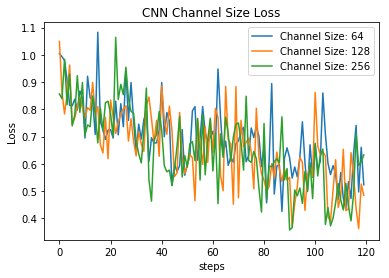

In [198]:
plt.plot(losslist4,label = 'Channel Size: 64')
plt.plot(losslist5,label = 'Channel Size: 128')
plt.plot(losslist6,label = 'Channel Size: 256')
plt.xlabel('steps')
plt.ylabel('Loss')
plt.title('CNN Channel Size Loss')
plt.legend(loc = 'upper right')
#plt.show()
plt.savefig('./image/CNN_channel_loss.png',dpi = 200)

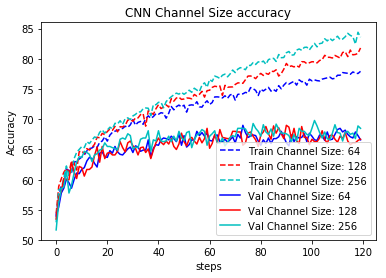

In [199]:
plt.plot(train_acc_list4,'b--',label = 'Train Channel Size: 64')
plt.plot(train_acc_list5,'r--',label = 'Train Channel Size: 128')
plt.plot(train_acc_list6,'c--',label = 'Train Channel Size: 256')
plt.plot(val_acc_list4,label = 'Val Channel Size: 64',color='Blue')
plt.plot(val_acc_list5,label = 'Val Channel Size: 128',color='Red')
plt.plot(val_acc_list6,label = 'Val Channel Size: 256',color = 'c')

plt.xlabel('steps')
plt.ylabel('Accuracy')
plt.title('CNN Channel Size accuracy')
plt.legend(loc = 'lower right')
#plt.show()
plt.savefig('./image/CNN_channel_train_val.png',dpi = 200)

In [239]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, sentence_length, kernel_size):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        #self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=1)
        self.globmax = nn.MaxPool1d(sentence_length, stride=sentence_length)

        self.linear1 = nn.Linear(hidden_size*2, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        #print(x[0].size())
        batch_size, seq_len, channel_len = x[0].size()

        #embed = self.embedding(x)
        hidden1 = self.conv1(x[0].transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))

        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        hidden1 = self.globmax(hidden1.transpose(1,2)).transpose(1,2)
        hidden2 = self.conv1(x[1].transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))

        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
        
        hidden2 = self.globmax(hidden2.transpose(1,2)).transpose(1,2)
                
        hidden = torch.cat((hidden1, hidden2), -1) 
        
        #hidden = torch.sum(hidden, dim=1)
        hidden = hidden.squeeze()
        hidden = self.linear1(hidden)
        hidden = F.relu(hidden)
        logits = self.linear2(hidden)
        return logits

In [240]:
def hyperparameter_testCNN(hidden_size,kernel_size,epochs = 6):
    def test_model(loader, model):
        """
        Help function that tests the model's performance on a dataset
        @param: loader - data loader for the dataset to test against
        """
        correct = 0
        total = 0
        model.eval()
        for data, lengths, labels in loader:
            data, lengths, labels = (data[0].to(device),data[1].to(device)), (lengths[0].to(device),lengths[1].to(device)), labels.to(device)
            data_batch, lengths_batch, label_batch = data, lengths, labels
            outputs = F.softmax(model(data_batch, lengths_batch), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]

            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
        return (100 * correct / total)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = CNN(emb_size=300, hidden_size=hidden_size, num_layers=2, num_classes=3, sentence_length=30,kernel_size = kernel_size)
    model.to(device)
    learning_rate = 3e-3
    num_epochs = epochs # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    
    losslist = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            data, lengths, labels = (data[0].to(device),data[1].to(device)), (lengths[0].to(device),lengths[1].to(device)), labels.to(device)
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data, lengths)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
#                 # validate
#                 val_acc = test_model(val_loader, model)
#                 print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
#                            epoch+1, num_epochs, i+1, len(train_loader), val_acc))

                train_acc = test_model(train_loader, model)
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {}, Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), train_acc,val_acc))
#         print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
#                    epoch+1, num_epochs, i+1, len(train_loader),val_acc))
                losslist.append(loss.data)
                train_acc_list.append(train_acc)
                val_acc_list.append(val_acc)
    return losslist,train_acc_list,val_acc_list


In [625]:
#losslist7,train_acc_list7,val_acc_list7 = hyperparameter_testCNN(128,kernel_size = 3, epochs = 8)
#losslist8,train_acc_list8,val_acc_list8 = hyperparameter_testCNN(128, kernel_size = 3, epochs = 8)
#losslist6,train_acc_list6,val_acc_list6 = hyperparameter_testCNN(512, kernel_size = 3, epochs = 8)

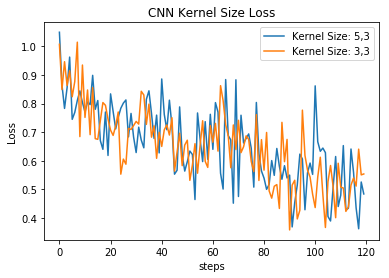

In [242]:
plt.plot(losslist5,label = 'Kernel Size: 5,3')
plt.plot(losslist7,label = 'Kernel Size: 3,3')
#plt.plot(losslist8,label = 'Kernel Size: 2,2')
plt.xlabel('steps')
plt.ylabel('Loss')
plt.title('CNN Kernel Size Loss')
plt.legend(loc = 'upper right')
#plt.show()
plt.savefig('./image/CNN_Kernel_loss.png',dpi = 200)

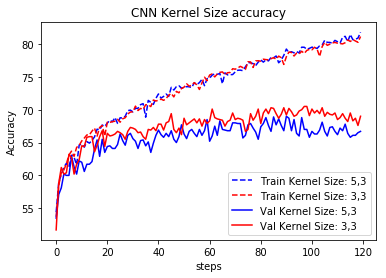

In [243]:
plt.plot(train_acc_list5,'b--',label = 'Train Kernel Size: 5,3')
plt.plot(train_acc_list7,'r--',label = 'Train Kernel Size: 3,3')
#plt.plot(train_acc_list8,'c--',label = 'Train Kernel Size: 2,2')
plt.plot(val_acc_list5,label = 'Val Kernel Size: 5,3',color='Blue')
plt.plot(val_acc_list7,label = 'Val Kernel Size: 3,3',color='Red')
#plt.plot(val_acc_list8,label = 'Val Kernel Size: 2,2',color = 'c')

plt.xlabel('steps')
plt.ylabel('Accuracy')
plt.title('CNN Kernel Size accuracy')
plt.legend(loc = 'lower right')
#plt.show()
plt.savefig('./image/CNN_Kernel_train_val.png',dpi = 200)

In [205]:
np.max(val_acc_list1),np.max(val_acc_list2),np.max(val_acc_list3),np.max(val_acc_list4),np.max(val_acc_list5),np.max(val_acc_list6),np.max(val_acc_list7)

(71.299999999999997,
 71.400000000000006,
 71.099999999999994,
 69.0,
 69.0,
 69.799999999999997,
 70.5)